## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, masking_type, **masking_args):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), masking_type=masking_type, **masking_args)
    psnr = 10 * torch.log10(1 / loss)
    print(f"Loss: {loss.item():.2f}, PSNR: {psnr.item():.2f}")

    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

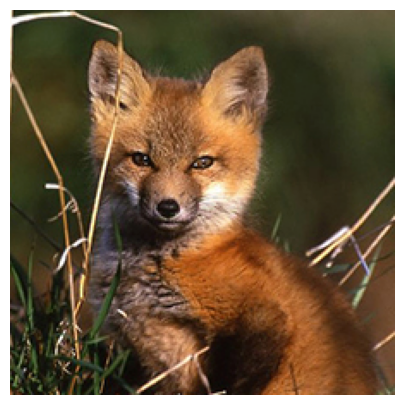

In [5]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img_url = 'https://www.travelandleisure.com/thmb/h97kSvljd2QYH2nUy3Y9ZNgO_pw=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/plane-data-BUSYROUTES1217-f4f84b08d47f4951b11c148cee2c3dea.jpg'
# img_url = 'https://www.dailypaws.com/thmb/ZHs0nxwPjwixC4YkqyRcO9DB2bg=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/striped-cat-playing-flower-552781357-2000-f8b1f07162594830bdba8a24e2268ad6.jpg'
# img_url = 'https://cv.cs.columbia.edu/sachit/classviadescr/static/datasets/ImageNet-ILSVRC2012/val/n01443537/ILSVRC2012_val_00018075.JPEG'

# img_path = "/media/ingo/539ea23b-a9e6-475b-993c-4f8f7eab2ac0/imagenet-mini/train/n04592741/n04592741_12494.JPEG"
# img_path = "/media/ingo/539ea23b-a9e6-475b-993c-4f8f7eab2ac0/imagenet-mini/train/n03764736/n03764736_7851.JPEG"

img = Image.open(requests.get(img_url, stream=True).raw)
# img = Image.open(img_path)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [18]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

# chkpt_dir = '../mae_visualize_vit_large.pth'
# chkpt_dir = '../jobs/20240707032625/outputs/checkpoint-10.pth'
# model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
# model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
# print('Model loaded.')


### Run MAE on the image

/tmp/ipykernel_77217/1206542589.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>
<All keys matched successfully>
Loss: 0.36, PSNR: 4.38


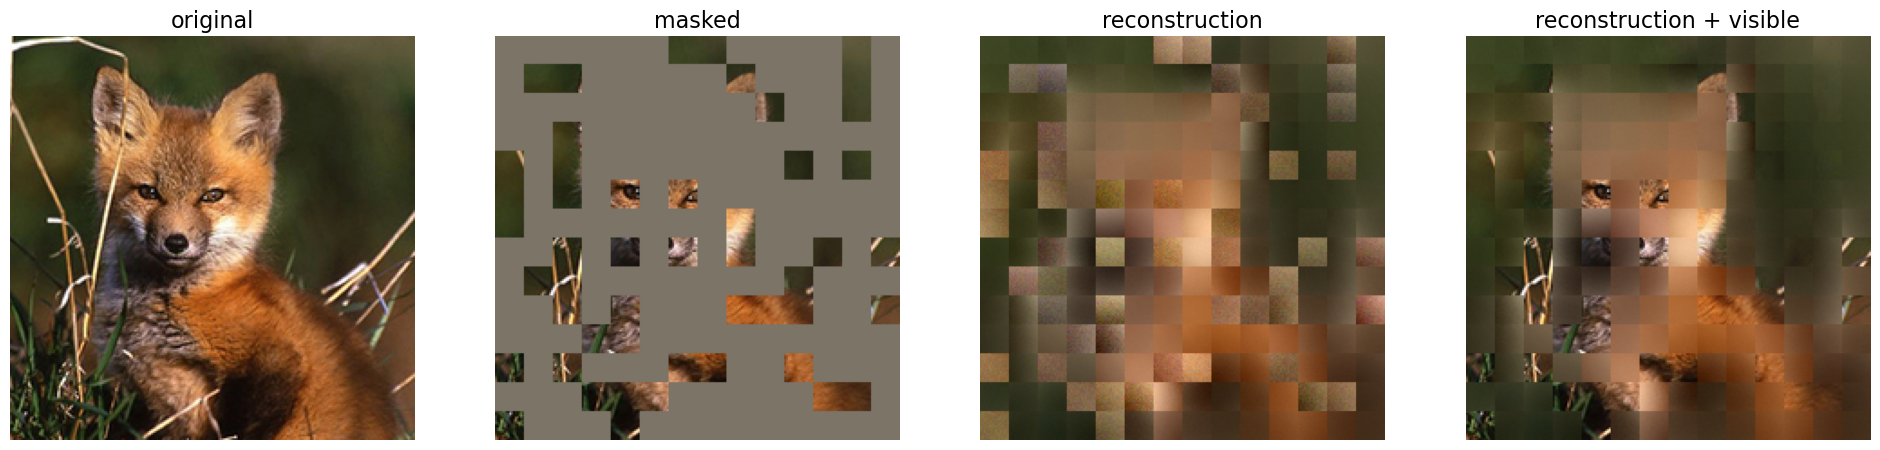

Loss: 0.34, PSNR: 4.66


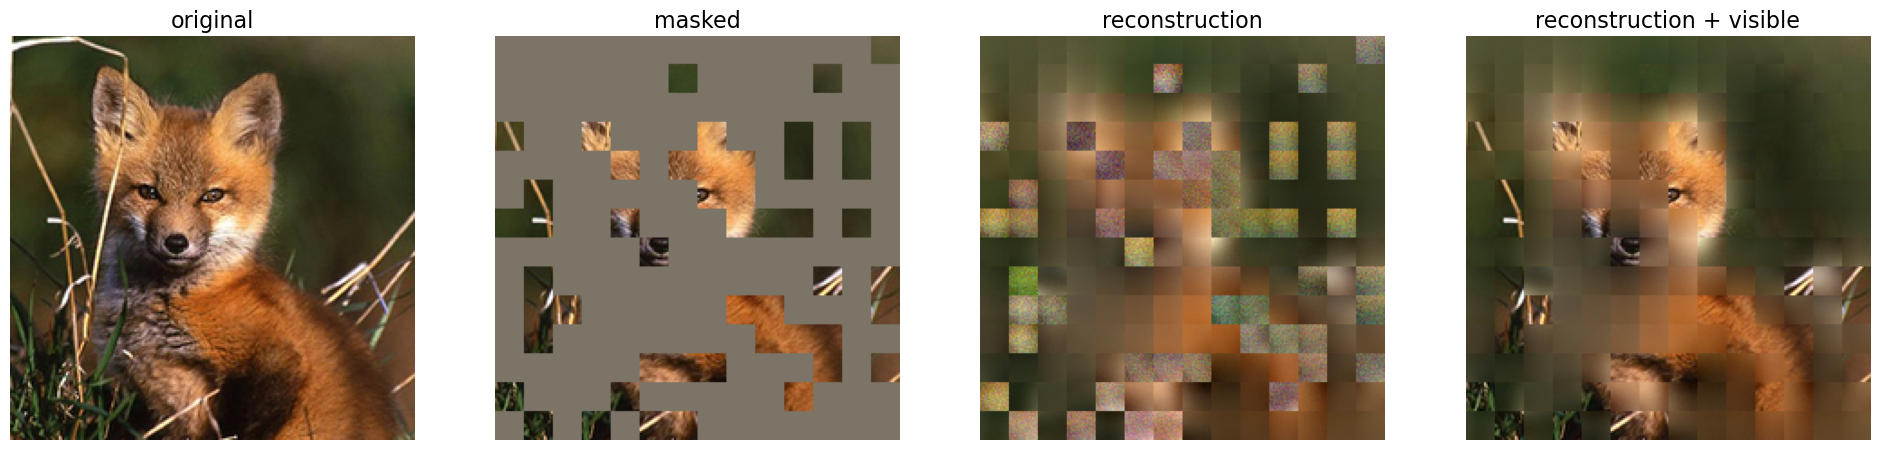

Loss: 0.41, PSNR: 3.86


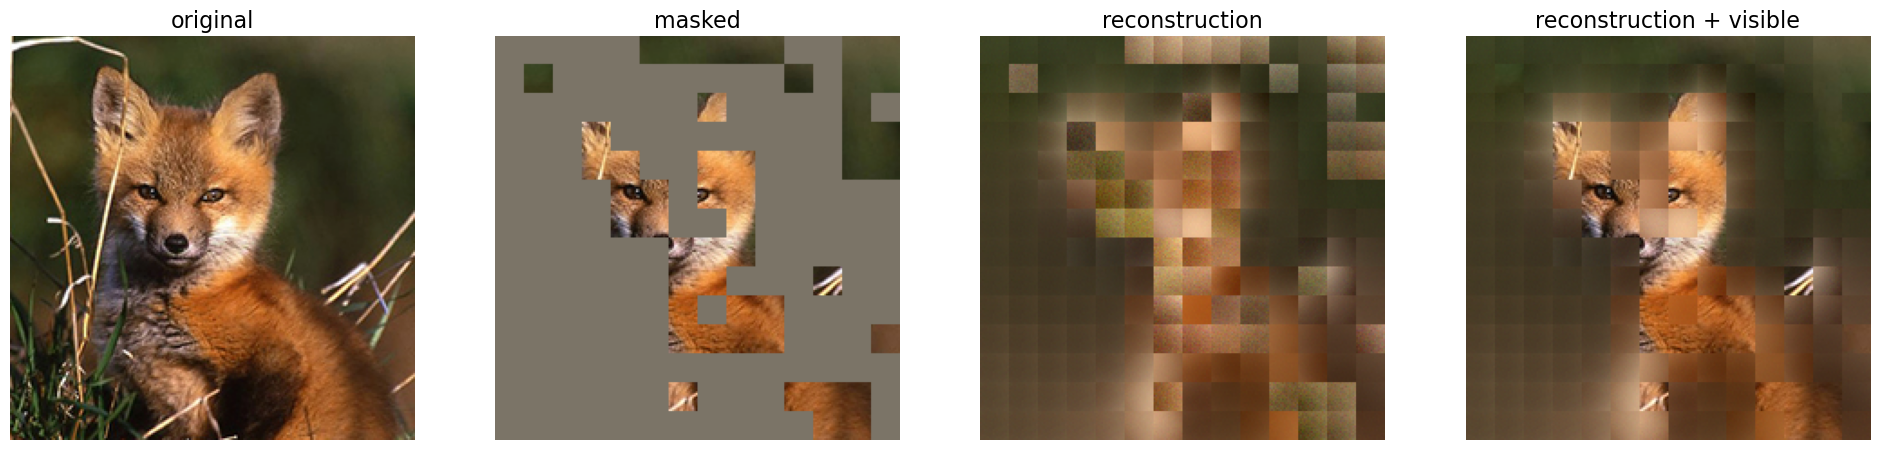

Loss: 0.52, PSNR: 2.82


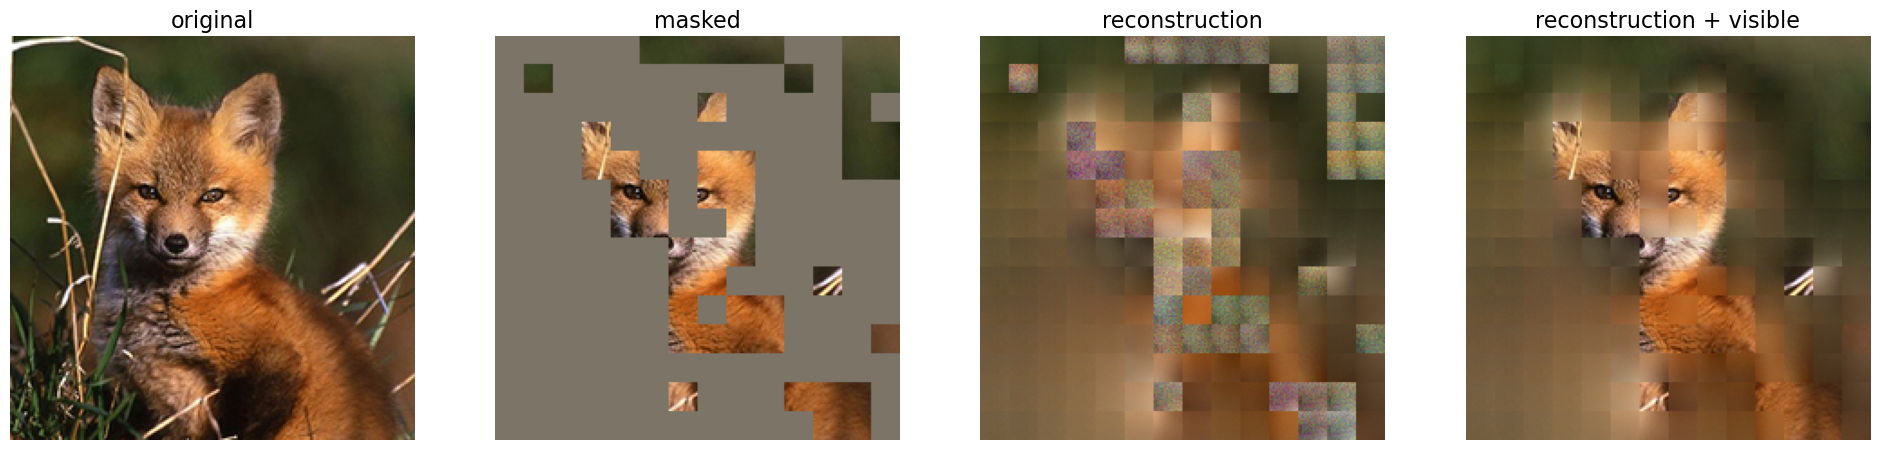

In [6]:
# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)

masking_args = {
    'masking_ratio': 0.75,
    # 'reverse': True,
}

# chkpt_dir = '../mae_visualize_vit_large.pth'
# model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
# run_one_image(img, model_mae, masking_type='entropy_masking_threshold', **masking_args)
# run_one_image(img, model_mae, masking_type='random_masking', **masking_args)
# run_one_image(img, model_mae, masking_type='entropy_masking', **masking_args)

chkpt_dir = "/home/ingo/Desktop/code_stuff/mae/jobs/20240820044336_entropy/outputs/checkpoint-399.pth"
chkpt_dir2 = "/home/ingo/Desktop/code_stuff/mae/jobs/20240815093102_random/outputs/checkpoint-399.pth"
model_mae1 = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
model_mae2 = prepare_model(chkpt_dir2, 'mae_vit_base_patch16')

run_one_image(img, model_mae1, masking_type='random_masking', **masking_args)
run_one_image(img, model_mae2, masking_type='random_masking', **masking_args)

run_one_image(img, model_mae1, masking_type='entropy_masking', **masking_args)
run_one_image(img, model_mae2, masking_type='entropy_masking', **masking_args)


### Load another pre-trained MAE model

In [ ]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = '../mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('../mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

### Run MAE on the image

In [ ]:
# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)